# AXA Data Challenge
## A) Modellierung
### 1. Daten Exploration

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1)

In [163]:
freq_df = pd.read_csv("freMTPL2freq.csv")
sev_df = pd.read_csv("freMTPL2sev.csv")
freq_df.head(10)
freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  int64  
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  int64  
 5   VehAge      678013 non-null  int64  
 6   DrivAge     678013 non-null  int64  
 7   BonusMalus  678013 non-null  int64  
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  int64  
 11  Region      678013 non-null  object 
dtypes: float64(2), int64(6), object(4)
memory usage: 62.1+ MB


There are no missing values. 

We can separate the data into the primary key `IDpol`, the target variable `ClaimNb`, the `Exposure`, which we will treat separately, and into numerical and categorical predictors as follows:

In [164]:
num_predictors = ["VehPower", "VehAge", "DrivAge", "BonusMalus","Density"]
num_columns = ["ClaimNb", "Exposure"]+num_predictors
cat_predictors = ["Area", "VehBrand", "VehGas", "Region"]

In [165]:
freq_df[num_columns].describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


There may be data quality issues concerning the extreme values of 100 years for both `VehAge` and `DrivAge`. 

We also observe that there are some policies which have an exposure of more than 1 year. The data set is supposed to capture the exposure and claims during one given year, so there must be some errors. One should investigate what happened and fix these observations, but because they are only a very small percentage of all policies, we ignore them.

In [166]:
freq_df[cat_predictors].describe()

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,'C','B12','Regular','R24'
freq,191880,166024,345877,160601


Now, we look at the claims amounts:

In [167]:
sev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  int64  
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 416.4 KB


Before we do anything else, we add the policy information to each claim. For this, we use a left join, thereby deleting all claims for which we don't have the policy information.

In [168]:
sev_df = sev_df.merge(right=freq_df.drop(columns=["ClaimNb", "Exposure"]), how="inner", on="IDpol")
print(f"Remaining claims: {sev_df.shape[0]}")
sev_df.head(5)

Remaining claims: 26444


,IDpol,ClaimAmount,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1552,995.20,'D',11,0,39,56,'B12','Diesel',778,'R22'
1,1552,1845.74,'D',11,0,39,56,'B12','Diesel',778,'R22'
2,1010996,1128.12,'E',4,1,49,50,'B12','Regular',2354,'R11'
3,4024277,1851.11,'D',4,2,32,106,'B12','Regular',570,'R31'
4,4007252,1204.00,'C',4,1,49,57,'B12','Regular',288,'R73'


### 2. Data Analysis

First, we look at the distribution of `ClaimNb`:

([<matplotlib.axis.XTick at 0x2828edd5310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

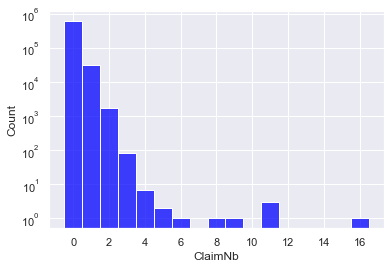

In [169]:
sns.histplot(x=freq_df.ClaimNb, color="blue", discrete=True, log_scale=(False, True))
plt.xticks(range(0,17,2))

Modelling this target variable as a Poisson distribution is supported by mean and variance being approximately equal:

In [170]:
mean = freq_df.ClaimNb.mean()
var = freq_df.ClaimNb.var()
print(mean, var)

0.05324676665491664 0.05765633238094156


However, there are much more extreme observations than expected from the fitted Poisson distribution:

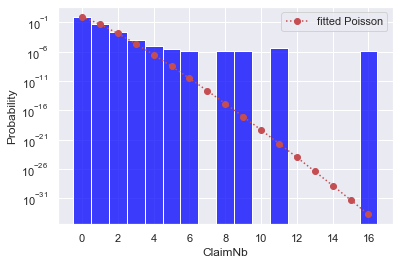

In [171]:
from scipy.stats import poisson
sns.histplot(x=freq_df.ClaimNb, color="blue", discrete=True, stat="probability")
plt.yscale("log")
plt.xticks(range(0,17,2))
plt.plot(range(17), [poisson.pmf(k, mu=mean) for k in range(17)] , color='r', ls=':', marker="o",label='fitted Poisson')
plt.legend()

We should keep that in mind. However, for the bulk of the data, the Poisson assumption is not bad, though we still notice some overdispersion.

In [172]:
print(f"Proportion of policies with ClaimNb<4: {sum(freq_df.ClaimNb < 4) / freq_df.shape[0]}")

Proportion of policies with ClaimNb<4: 0.9999764016324171


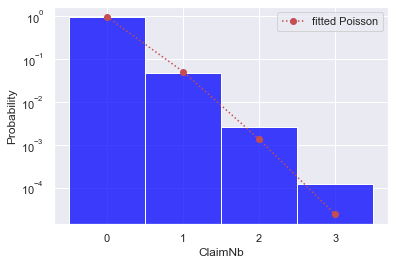

In [173]:
sns.histplot(x=freq_df.ClaimNb[freq_df.ClaimNb < 4], color="blue", discrete=True, stat="probability")
plt.yscale("log")
plt.xticks(range(0,4))
plt.plot(range(4), [poisson.pmf(k, mu=freq_df.ClaimNb[freq_df.ClaimNb < 4].mean()) for k in range(4)] , color='r', ls=':', marker="o", label='fitted Poisson')
plt.legend()

Now, we take a look at the distribution of `ClaimAmount`:

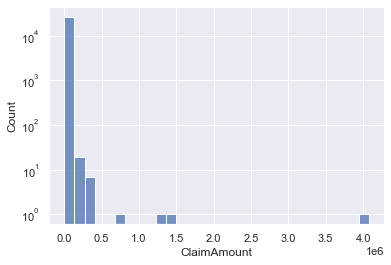

In [174]:
sns.histplot(sev_df.ClaimAmount, bins=30) 
plt.yscale("log")

For a more useful visualization (without logarithmic y-axis), we need to exclude some outliers. First, we try doing this by capping the ClaimAmount at 20k, which is a bit more than the 99th percentile:

In [175]:
quantile99 = round(sev_df.ClaimAmount.quantile(0.99),1)
print(quantile99)

16451.2


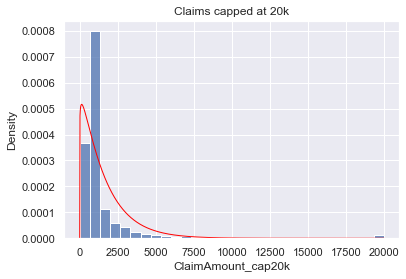

In [176]:
sev_df["ClaimAmount_cap20k"] = sev_df.ClaimAmount.map(lambda x: min(x,2e4))
sns.histplot(sev_df.ClaimAmount_cap20k, bins=30, stat="density")\
 .set(title="Claims capped at 20k")

from scipy.stats import gamma
shape, loc, scale = gamma.fit(sev_df.ClaimAmount_cap20k)
xs=np.linspace(0, 20000, 1000)
plt.plot(xs, gamma.pdf(xs, a=shape, loc=loc, scale=scale), color="red", linewidth=1)

Let's zoom in a bit more:

In [177]:
quantile95 = round(sev_df.ClaimAmount.quantile(0.95),1)
print(quantile95)

4765.1


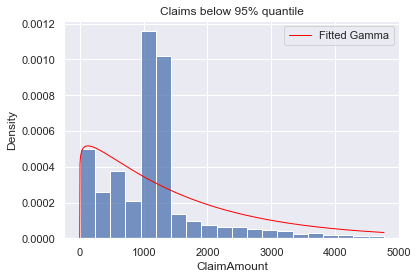

In [178]:
sns.histplot(sev_df.ClaimAmount[sev_df.ClaimAmount <= quantile95], bins=20, stat="density")\
 .set(title="Claims below 95% quantile")
xs=np.linspace(0, quantile95, 1000)
plt.plot(xs, gamma.pdf(xs, a=shape, loc=loc, scale=scale), color="red", linewidth=1, label="Fitted Gamma")
plt.legend()

The peak at roughly 1000€ is worrisome and causes the bad fit of the Gamma distribution. Maybe this value is entered as an estimate for a yet unknown claims amount? Let's find out if there are in fact many claims with the exact claim amount of 1000€:

In [179]:
sum(sev_df.ClaimAmount == 1000)

49

In [180]:
sev_df.ClaimAmount.value_counts()

1204.00    4792
1128.12    3056
1172.00    2071
1128.00     831
602.00      433
           ... 
143.77        1
296.52        1
492.28        1
1507.10       1
767.55        1
Name: ClaimAmount, Length: 12255, dtype: int64

The first hypothesis has to be rejected. It seems that there are a few claim amounts between 1100€ and 1200€ that have lots of instances. I can only explain this as an artefact from data generation. Though the peak in of itself (and not its concentration in a few values) could result from customers only reporting damages that exceed their deductible (Selbstbehalt).

Next, we look at all the numerical predictors.

array([[<AxesSubplot:title={'center':'Exposure'}>,
        <AxesSubplot:title={'center':'VehPower'}>,
        <AxesSubplot:title={'center':'VehAge'}>],
       [<AxesSubplot:title={'center':'DrivAge'}>,
        <AxesSubplot:title={'center':'BonusMalus'}>,
        <AxesSubplot:title={'center':'Density'}>]], dtype=object)

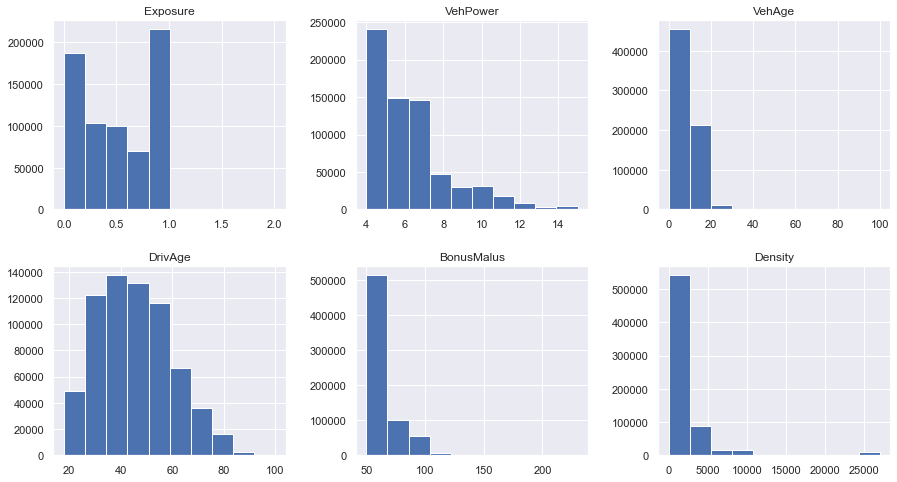

In [181]:
freq_df[["Exposure"]+num_predictors].hist(layout=(2,3), figsize=(15,8))

On the other hand, the scarcity of data with high values in `Density, BonusMalus, Density` could pose problems, which we will address in the preprocessing step.

For each of the numerical predictors, we consider the overall claim frequency and average claim amount, grouped by a binned version of this predictor.

In [182]:
from sklearn.preprocessing import KBinsDiscretizer
def overview_plot(frequency_df, severity_df, predictor, bins):
    '''Bins predictor, plots overall claim frequency, exposure, average claim amount and number of claims grouped by this binned predictor'''
    
    df1 = frequency_df[["ClaimNb", "Exposure"]]
    discretizer = KBinsDiscretizer(n_bins=bins, encode="ordinal", strategy="uniform")
    df1["bin"] = discretizer.fit_transform(frequency_df[[predictor]])
    df1["weighted_predictor"] = frequency_df[predictor]*frequency_df["Exposure"]
    df1_agg = df1.groupby("bin").sum()
    df1_agg[predictor] = df1_agg["weighted_predictor"] / df1_agg["Exposure"] #Exposure-weighted average of predictor by bin
    df1_agg["Claim Frequency"] = df1_agg["ClaimNb"] / df1_agg["Exposure"]
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
    sns.lineplot(data = df1_agg, x=predictor, y="Claim Frequency", marker="o", ax=axes[0,0])
    axes[0,0].set(xlabel=predictor + " (binned)")
    sns.lineplot(data = df1_agg, x=predictor, y="Exposure", marker="o", ax=axes[0,1])
    axes[0,1].set(xlabel=predictor + " (binned)")
    
    df2 = severity_df[["ClaimAmount_cap20k", predictor]]
    df2["bin"] = discretizer.transform(df2[[predictor]])
    df2_agg = df2.groupby("bin").agg({predictor: "mean", "ClaimAmount_cap20k": "mean", "bin":"size"})
    df2_agg.rename({"bin": "Count"}, axis=1, inplace=True)
    sns.lineplot(data = df2_agg, x=predictor, y="ClaimAmount_cap20k", marker="o", ax=axes[1,0])
    axes[1,0].set(xlabel=predictor + " (binned)")
    sns.lineplot(data = df2_agg, x=predictor, y="Count", marker="o", ax=axes[1,1])
    axes[1,1].set(xlabel=predictor + " (binned)")

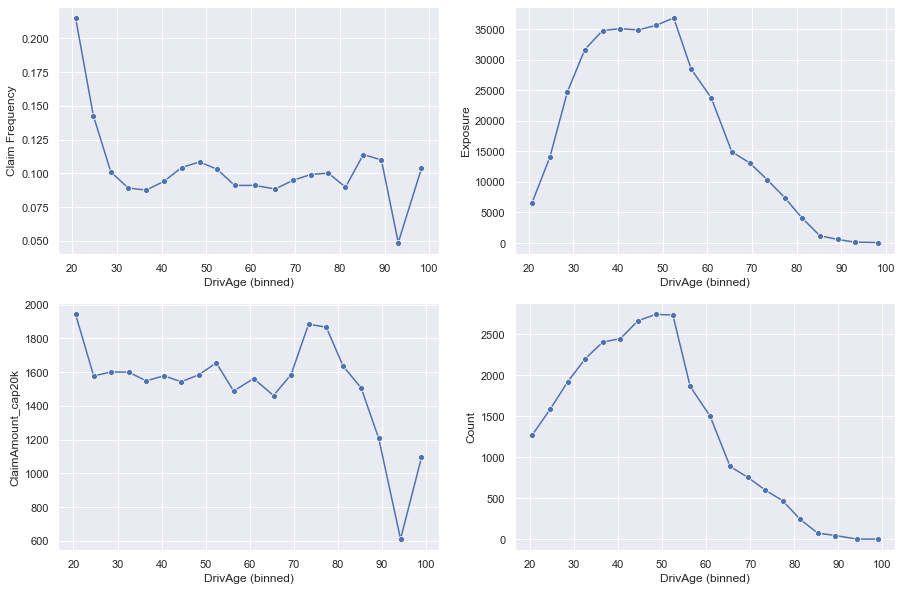

In [183]:
import warnings
warnings.filterwarnings('ignore')

overview_plot(freq_df, sev_df, "DrivAge", 20)

Very young drivers cause more and more expensive damages. This effect stabilizes around age 30 and after that, the changes in average claim frequency and amount are rather small, and not easy to justify with an intuition. For roughly age 75 and older, we don't have a lot of data. This leads me to the following choice of discretization:

In [184]:
bins_DrivAge = [17,18,19,22,26,30,40,55,75, np.Inf] # intervals are left-open, right-closed!
freq_df["DrivAge_binned"] = pd.cut(freq_df["DrivAge"], bins=bins_DrivAge)
sev_df["DrivAge_binned"] = pd.cut(sev_df["DrivAge"], bins=bins_DrivAge)

I.e the bins are: 18, 19, 20-22, 23-26, 27-30, 31-40, 41-55, 56-75, 76+

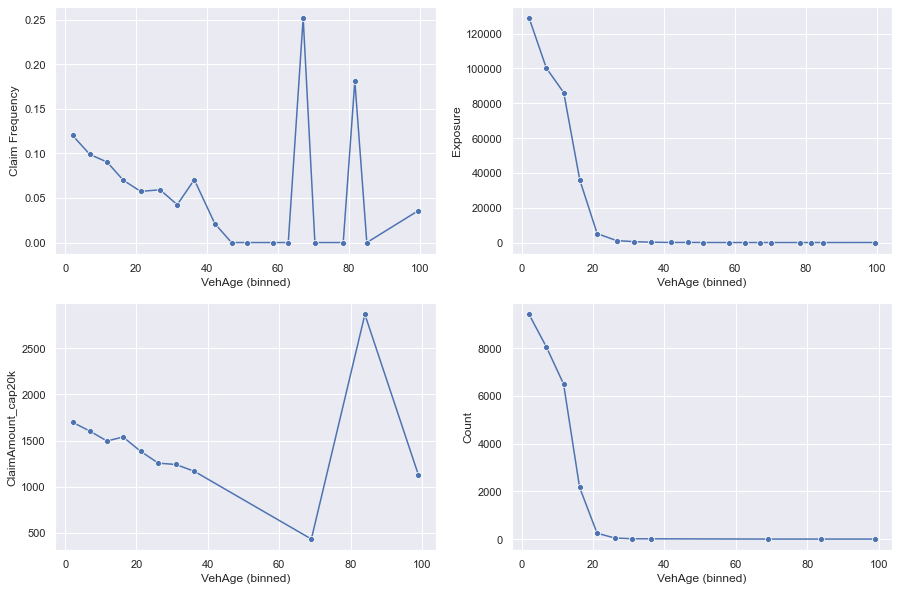

In [185]:
overview_plot(freq_df, sev_df, "VehAge", 20)

In [186]:
sev_df[sev_df.VehAge > 20]

,IDpol,ClaimAmount,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount_cap20k,DrivAge_binned
4392,45112,1128.12,'E',13,22,47,80,'B10','Diesel',9307,'R82',1128.12,"(40.0, 55.0]"
4595,39161,1409.82,'B',7,29,52,60,'B2','Regular',73,'R24',1409.82,"(40.0, 55.0]"
4611,39206,1128.12,'E',4,26,66,62,'B14','Regular',6681,'R11',1128.12,"(55.0, 75.0]"
4791,46884,1128.12,'C',5,26,34,100,'B2','Regular',128,'R24',1128.12,"(30.0, 40.0]"
5027,128077,274.52,'A',4,22,66,50,'B2','Regular',45,'R54',274.52,"(55.0, 75.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25814,2287004,5500.00,'C',8,21,28,64,'B2','Regular',355,'R91',5500.00,"(26.0, 30.0]"
25974,2286249,1599.00,'C',8,22,41,50,'B1','Regular',144,'R93',1599.00,"(40.0, 55.0]"
25995,3250760,1641.10,'E',8,35,37,57,'B2','Regular',9307,'R82',1641.10,"(30.0, 40.0]"
26184,2221433,1169.45,'E',4,21,68,50,'B4','Regular',3963,'R91',1169.45,"(55.0, 75.0]"


In [187]:
freq_df[freq_df.VehAge > 40]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,DrivAge_binned
7767,21836.0,1,0.24,'C',5,42,75,50,'B1','Regular',405,'R24',"(55.0, 75.0]"
11019,27814.0,0,0.62,'C',6,59,56,50,'B1','Regular',393,'R24',"(55.0, 75.0]"
13062,31596.0,0,0.60,'A',11,46,29,50,'B1','Regular',28,'R24',"(26.0, 30.0]"
13326,32078.0,0,1.00,'A',4,46,53,50,'B1','Regular',48,'R24',"(40.0, 55.0]"
20638,45432.0,0,0.60,'E',4,100,32,68,'B2','Regular',2586,'R82',"(30.0, 40.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595756,4186934.0,0,0.21,'A',4,52,59,50,'B1','Regular',34,'R54',"(55.0, 75.0]"
596469,4187647.0,0,0.20,'A',6,48,43,50,'B2','Diesel',30,'R24',"(40.0, 55.0]"
596792,4187970.0,0,1.00,'A',11,44,40,50,'B2','Regular',29,'R24',"(30.0, 40.0]"
597120,4188298.0,0,0.79,'B',4,48,39,50,'B1','Regular',51,'R24',"(30.0, 40.0]"


We have a strong downwards trend the first few years, which afterwards continuous more slowly (both for claim frequency and severity). For vehicles over age 20, random effects take over. 

In [218]:
bins_VehAge = [-1,0,1,2,3,6,10,20, np.Inf]
freq_df["VehAge_binned"] = pd.cut(freq_df["VehAge"], bins=bins_VehAge)
sev_df["VehAge_binned"] = pd.cut(sev_df["VehAge"], bins=bins_VehAge)

I.e the bins are: 0, 1, 2, 3, 4-6, 7-10, 11-20, 20+

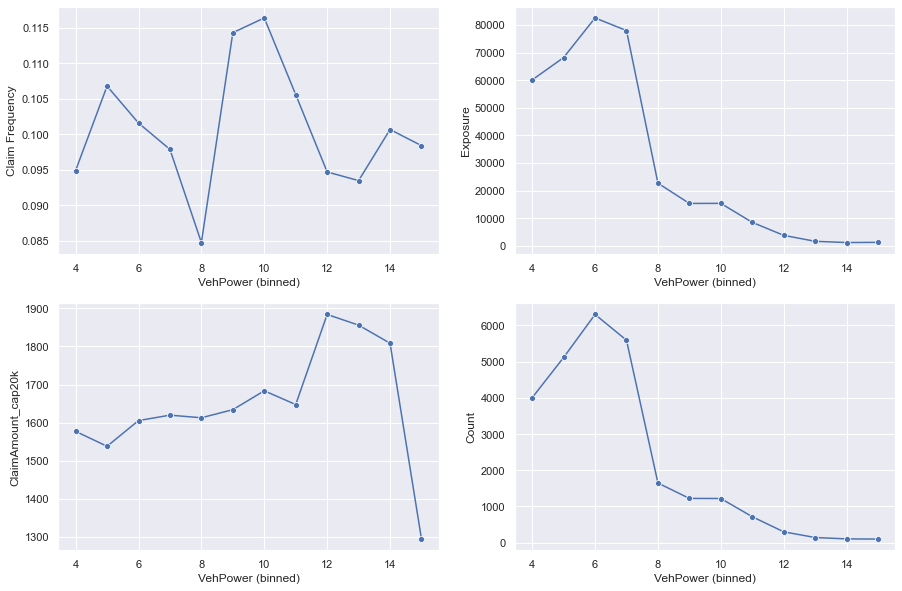

In [189]:
overview_plot(freq_df, sev_df, "VehPower", 40)

We let `VehPower` discretized as it is, expect we reset all values higher than 11 to 11 because there are too few observations for these values.

In [278]:
min11 = lambda x: min(x,11)
freq_df["VehPower_binned"] = freq_df["VehPower"].map(min11)
sev_df["VehPower_binned"] = sev_df["VehPower"].map(min11)

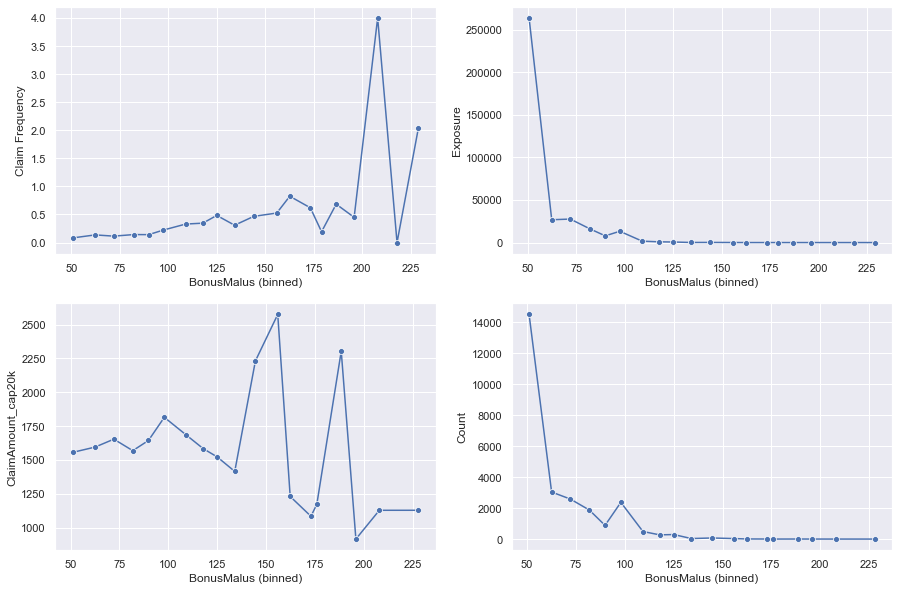

In [191]:
overview_plot(freq_df, sev_df, "BonusMalus", 20)

Only the first few data points are based on a good number of obserations. Looking at these, I think it is best to retain `BonusMalus` as a continuous variable for which a slope is estimated.

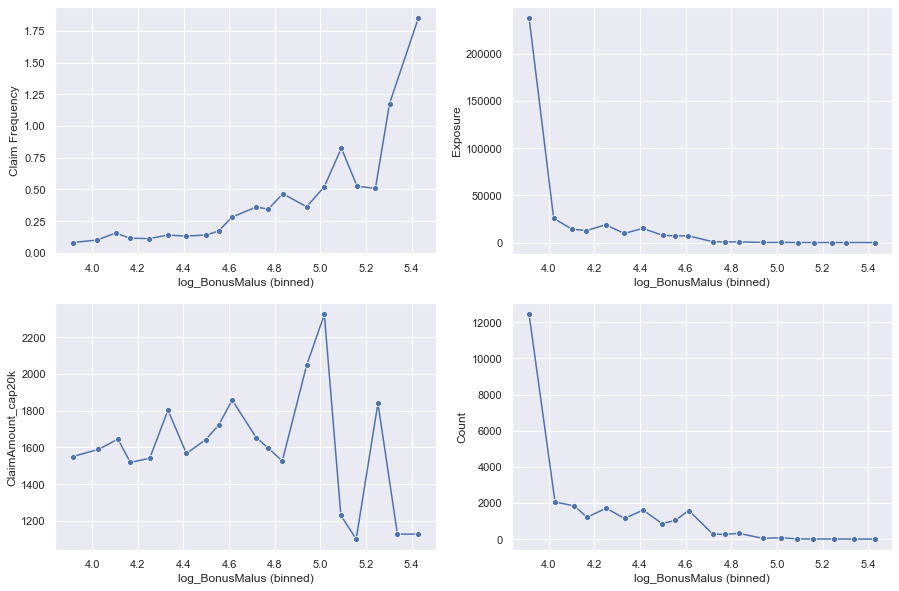

In [192]:
freq_df["log_BonusMalus"] = freq_df.BonusMalus.map(np.log)
sev_df["log_BonusMalus"] = sev_df.BonusMalus.map(np.log)
overview_plot(freq_df, sev_df, "log_BonusMalus", 20)

`BonusMalus` has a stronger influence on the claim frequency than the claim amount. Using the untransformed `BonusMalus` seems appropriate to me because the trend of the claim frequency w.r.t `BonusMalus` appears quite linear. 

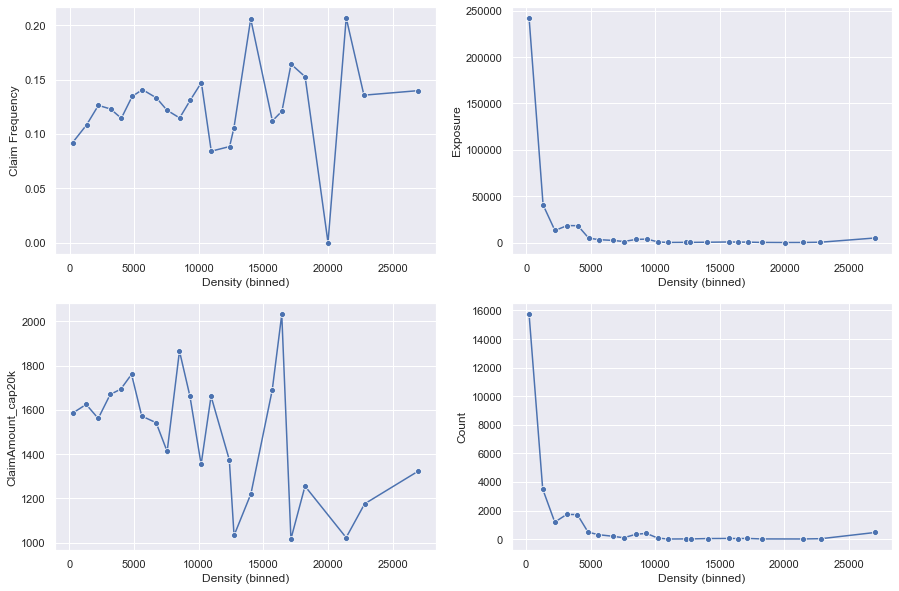

In [193]:
overview_plot(freq_df, sev_df, "Density", 30)

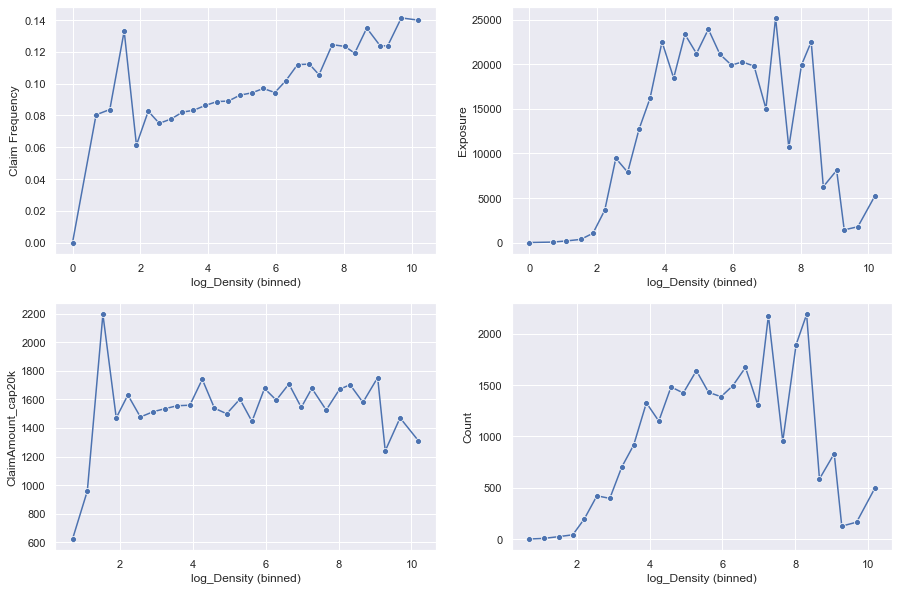

In [194]:
freq_df["log_Density"] = freq_df.Density.map(np.log)
sev_df["log_Density"] = sev_df.Density.map(np.log)
overview_plot(freq_df, sev_df, "log_Density", 30)

For the same reasons as before, we will use `log_Density` as a continuous predictor. It will probably only be useful for the frequency model.

Now, onto the categorical predictors. For each of them, we produce plots showing the overall claim frequency, average claim amount and overall exposure for each level.

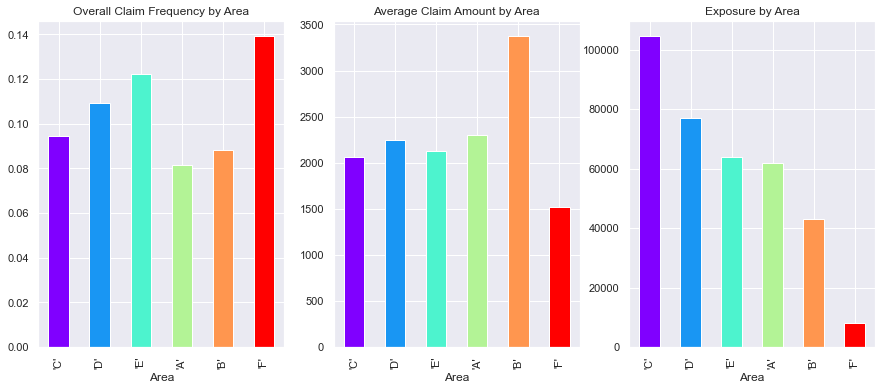

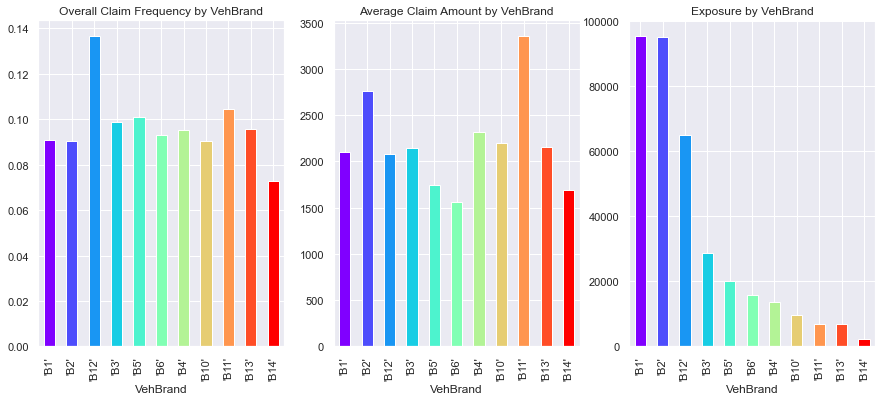

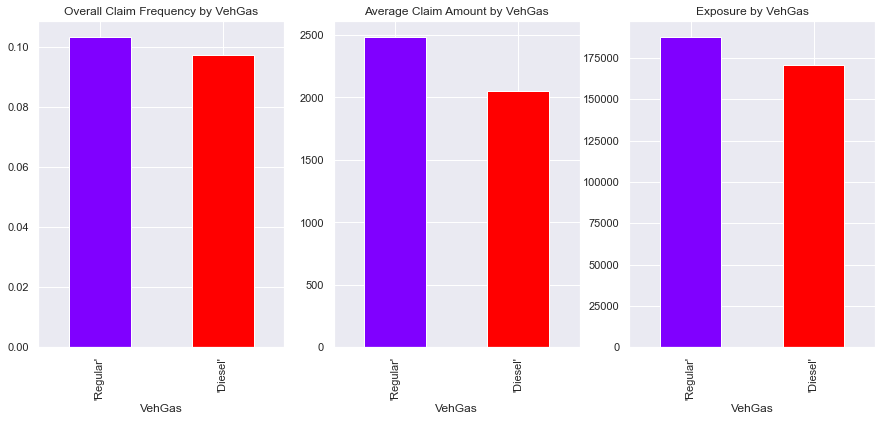

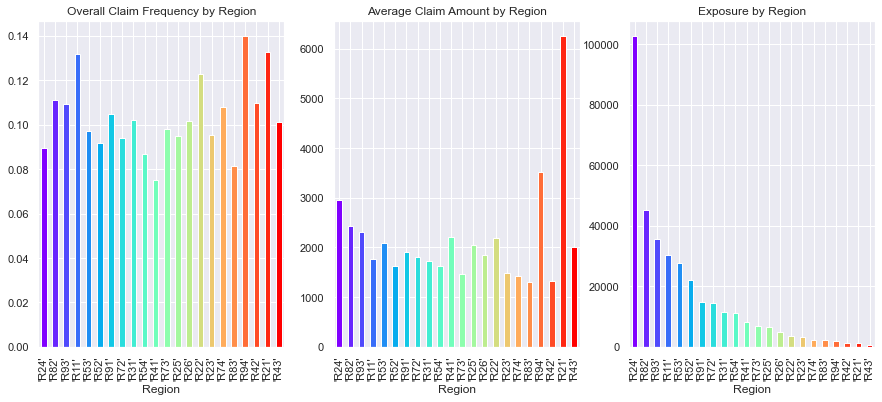

In [195]:
agg_dfs = dict()
for pred in cat_predictors:
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,6))
    agg_df = freq_df.groupby(pred).agg({"ClaimNb":"sum", "Exposure":"sum"}).sort_values(by="Exposure", ascending=False)
    agg_df["overall_freq"]  = agg_df.ClaimNb / agg_df.Exposure
    
    colors = plt.cm.rainbow(np.linspace(0,1,agg_df.shape[0]))
    agg_df["overall_freq"].plot(kind="bar", ax=axes[0], title=f"Overall Claim Frequency by {pred}", color=colors)
    agg_df["Exposure"].plot(kind="bar", ax=axes[2], title=f"Exposure by {pred}", color=colors)
    agg_df["Avg. Claim Amount"] = sev_df.groupby(pred).ClaimAmount.mean()
    agg_df["Avg. Claim Amount"].plot(kind="bar", ax=axes[1], title=f"Average Claim Amount by {pred}", color=colors)
    agg_dfs[pred] = agg_df

All categorical variables seem to carry relevant information. But, there are regions and probably also car brands for which we have too little data, such that we should group these together.

### 3. Preprocessing + Model Training

In [254]:
cat_features = ["DrivAge_binned", "VehAge_binned", "VehPower_binned", "Area", "Region", "VehBrand", "VehGas"]
num_features = ["BonusMalus", "log_Density"]
used_features = cat_features + num_features

In [255]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessing_freq = ColumnTransformer(
    transformers = [
        ("StandardScaler", StandardScaler(), num_features),
        ("OneHotEncoder", OneHotEncoder(), cat_features)
    ],
    remainder = "drop"
)

# separate but identical Transformer for severity model (will be slightly different after fitted)
preprocessing_sev = ColumnTransformer(
    transformers = [
        ("StandardScaler", StandardScaler(), num_features),
        ("OneHotEncoder", OneHotEncoder(), cat_features)
    ],
    remainder = "drop"
)

In [280]:
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
poisson_glm = PoissonRegressor(alpha=0.01, fit_intercept=True)
freq_model = Pipeline(steps=[("preprocessing", preprocessing_freq), ("glm", poisson_glm)])
freq_model.fit(freq_df[used_features], freq_df.ClaimNb/freq_df.Exposure, glm__sample_weight=freq_df.Exposure)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['BonusMalus',
                                                   'log_Density']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['DrivAge_binned',
                                                   'VehAge_binned',
                                                   'VehPower_binned', 'Area',
                                                   'Region', 'VehBrand',
                                                   'VehGas'])])),
                ('glm', PoissonRegressor(alpha=0.01))])

In [279]:
from sklearn.linear_model import GammaRegressor
gamma_glm = GammaRegressor(alpha=0.01, fit_intercept=True)
sev_model = Pipeline(steps=[("preprocessing", preprocessing_sev), ("glm", gamma_glm)])
sev_model.fit(sev_df[used_features], sev_df.ClaimAmount)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['BonusMalus',
                                                   'log_Density']),
                                                 ('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  ['DrivAge_binned',
                                                   'VehAge_binned',
                                                   'VehPower_binned', 'Area',
                                                   'Region', 'VehBrand',
                                                   'VehGas'])])),
                ('glm', GammaRegressor(alpha=0.01))])

### 4. Model Visualization

In [281]:
freq_pred_df = freq_df.copy()
freq_pred_df["ClaimNb"] = freq_model.predict(freq_df[used_features])*freq_df["Exposure"]
freq_pred_df["type"] = "Predicted"
   
freq_obs_df = freq_df.copy()
freq_obs_df["type"] = "Observed"
freq_comparison_df = pd.concat([freq_obs_df, freq_pred_df])

sev_pred_df = sev_df.copy()
sev_pred_df["ClaimAmount"] = sev_model.predict(sev_df[used_features])
sev_pred_df["type"] = "Predicted"
sev_obs_df = sev_df.copy()
sev_obs_df["type"] = "Observed"
sev_comparison_df = pd.concat([sev_obs_df, sev_pred_df])

In [282]:
def cat_comparison_plot(predictor):
    df1 = freq_comparison_df[["ClaimNb", "Exposure", "type", predictor]]
    df1_agg = df1.groupby([predictor, "type"]).sum().reset_index()
    df1_agg["Claim Frequency"] = df1_agg["ClaimNb"] / df1_agg["Exposure"]
    
    fig, axes = plt.subplots(ncols=2, figsize=(17,6))
    sns.barplot(data = df1_agg.reset_index(), x=predictor, y="Claim Frequency", hue="type", ax=axes[0])
    
    df2 = sev_comparison_df[["ClaimAmount", predictor, "type"]]
    df2_agg = df2.groupby([predictor, "type"]).mean().reset_index()
    sns.barplot(data = df2_agg, x=predictor, y="ClaimAmount", hue="type", ax=axes[1]).set(ylabel="Avg Claim Amount")
    
    axes[0].tick_params(labelrotation=45)
    axes[1].tick_params(labelrotation=45)

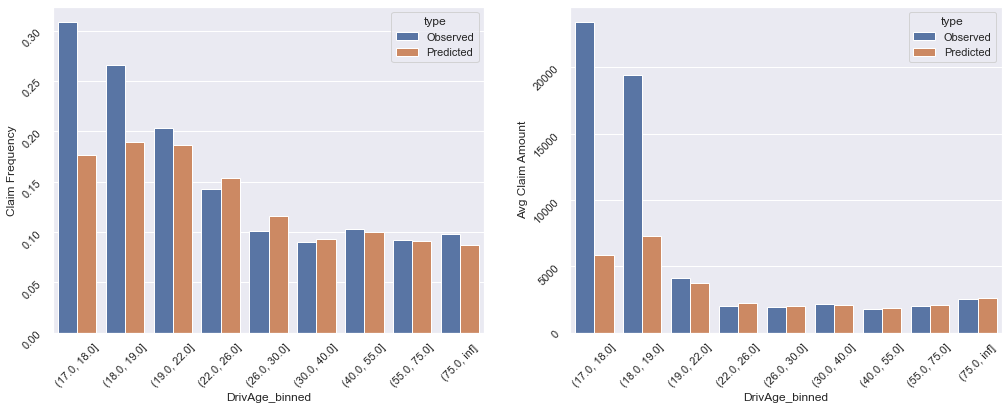

In [283]:
cat_comparison_plot("DrivAge_binned")

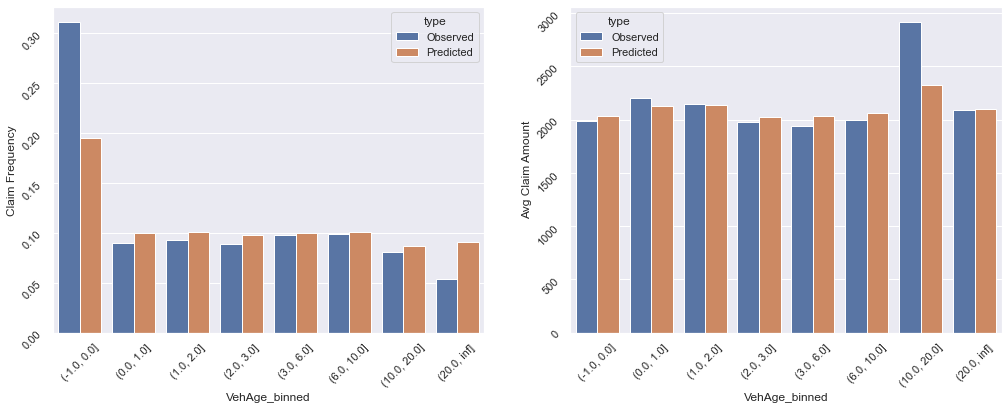

In [284]:
cat_comparison_plot("VehAge_binned")

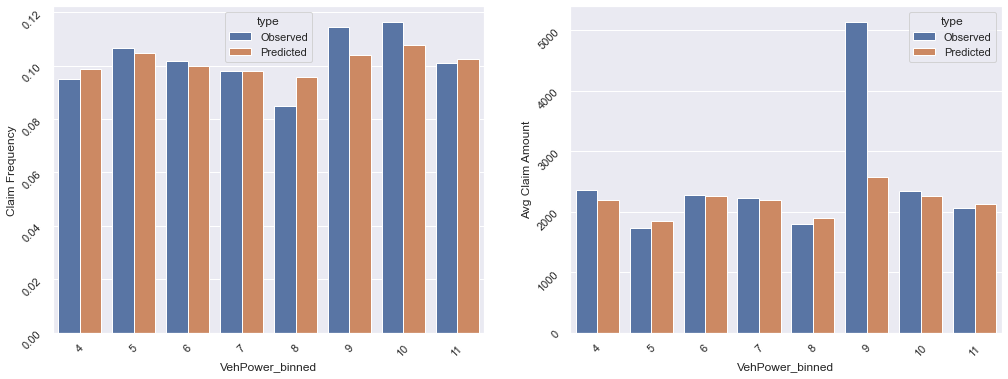

In [285]:
cat_comparison_plot("VehPower_binned")

In [286]:
def comparison_plot(predictor, bins):
    
    df1 = freq_comparison_df[["ClaimNb", "Exposure", "type", predictor]]
    discretizer = KBinsDiscretizer(n_bins=bins, encode="ordinal", strategy="quantile")
    df1["bin"] = discretizer.fit_transform(df1[[predictor]])
    df1["weighted_predictor"] = df1[predictor]*df1["Exposure"]
    df1_agg = df1.groupby(["bin", "type"]).sum()
    df1_agg[predictor] = df1_agg["weighted_predictor"] / df1_agg["Exposure"] #Exposure-weighted average of predictor by bin
    df1_agg["Claim Frequency"] = df1_agg["ClaimNb"] / df1_agg["Exposure"]
    
    fig, axes = plt.subplots(ncols=2, figsize=(15,6))
    sns.lineplot(data = df1_agg, x=predictor, y="Claim Frequency", hue="type", marker="o", ax=axes[0])
    axes[0].set(xlabel=predictor + " (binned)")
    
    df2 = sev_comparison_df[["ClaimAmount", predictor, "type"]]
    df2["bin"] = discretizer.transform(df2[[predictor]])
    df2_agg = df2.groupby(["bin", "type"]).mean()
    sns.lineplot(data = df2_agg, x=predictor, y="ClaimAmount", hue="type", marker="o", ax=axes[1])
    axes[1].set(xlabel=predictor + " (binned)")

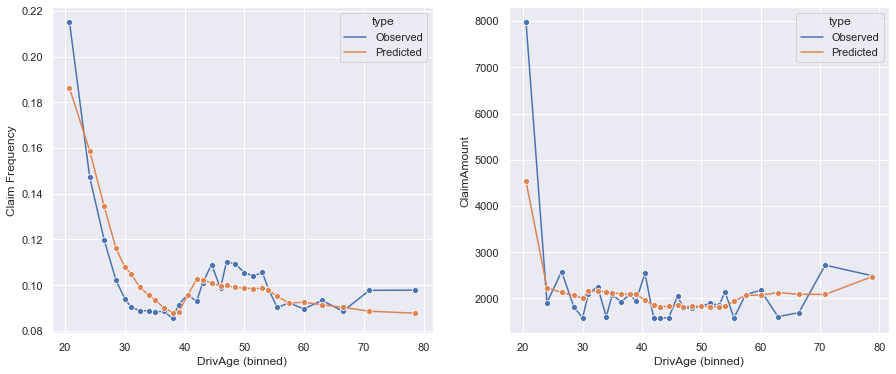

In [287]:
comparison_plot("DrivAge", 30)

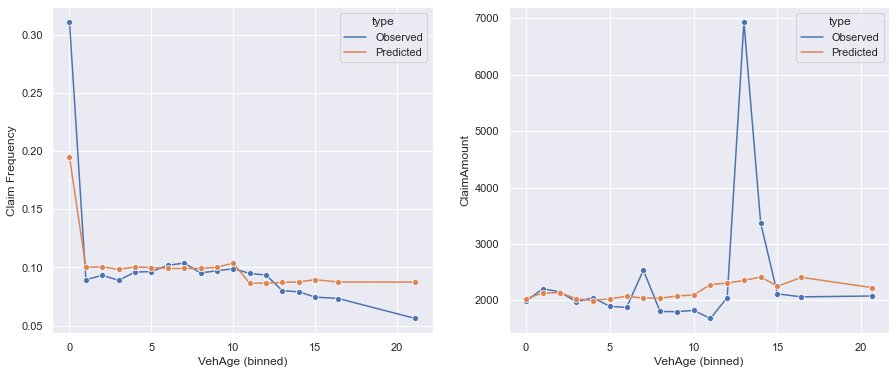

In [288]:
comparison_plot("VehAge", 30)

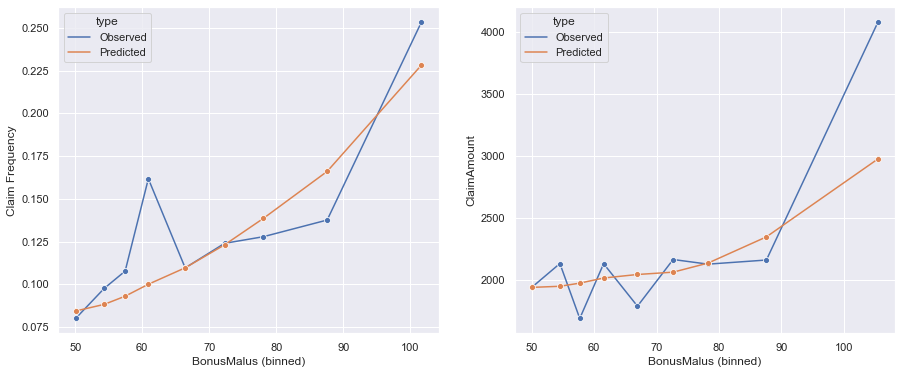

In [289]:
comparison_plot("BonusMalus", 20)

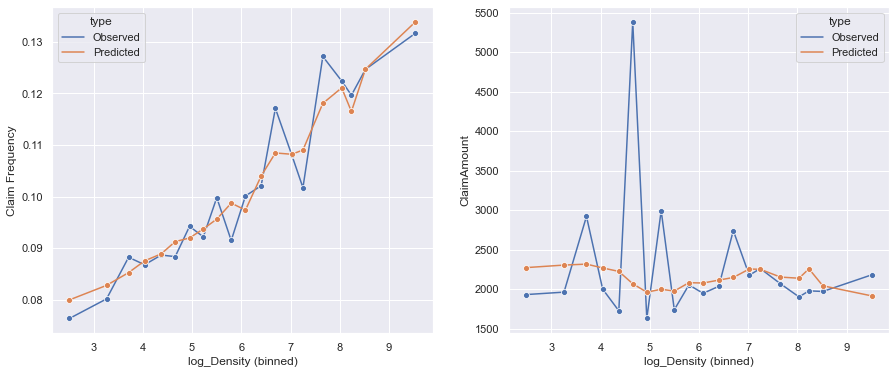

In [290]:
comparison_plot("log_Density", 20)

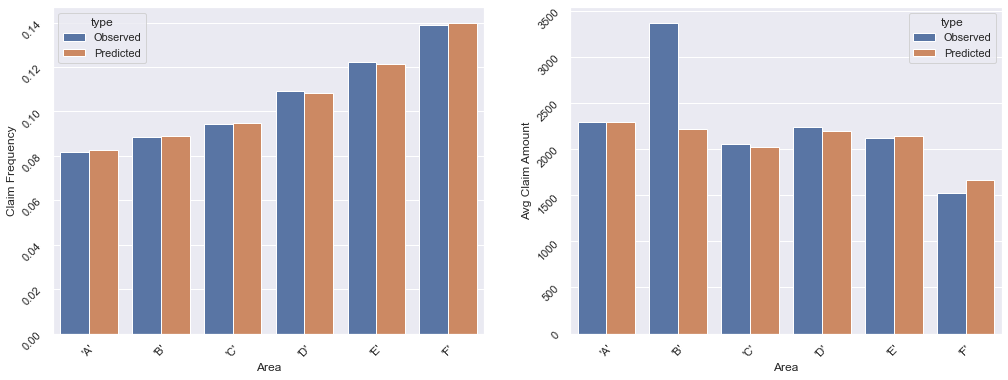

In [291]:
cat_comparison_plot("Area")

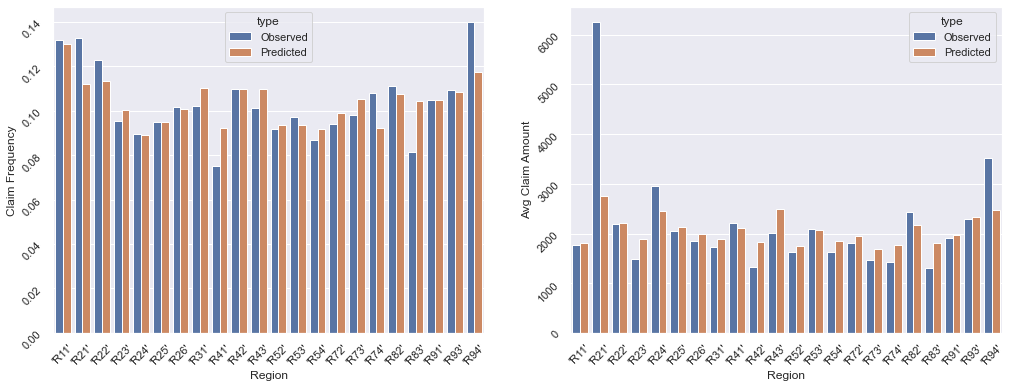

In [292]:
cat_comparison_plot("Region")

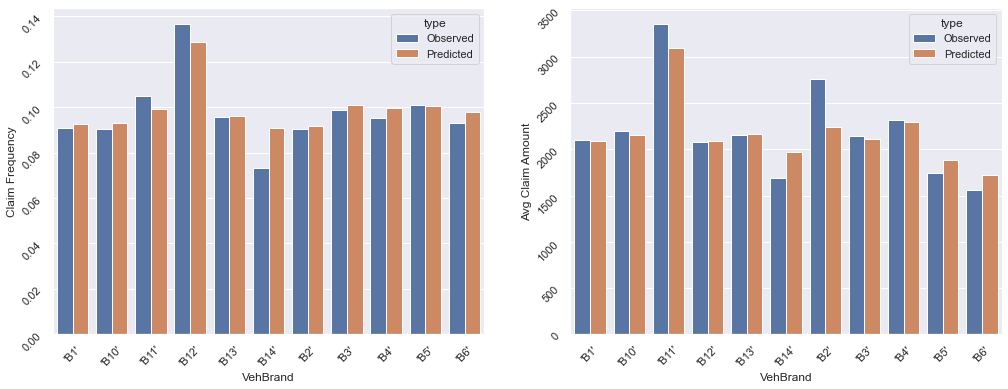

In [293]:
cat_comparison_plot("VehBrand")

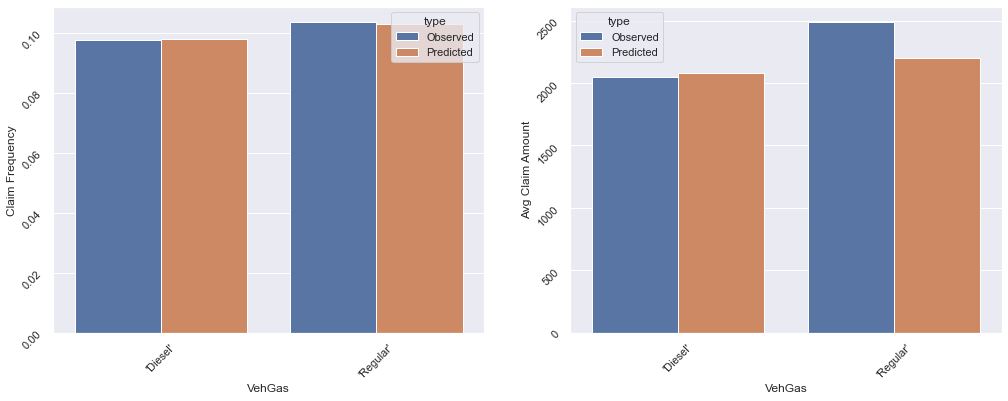

In [294]:
cat_comparison_plot("VehGas")

The performance is overall quite bad. In particular, the claim frequency is always over-estimated. I don't know why. To my best understanding of GLMs, the overall claim frequency over all policies should be estimated correctly.

### 4. Visualization of individual features' impact

In [295]:
dummy_df = pd.DataFrame()
for col in num_features:
    dummy_df[col] = [freq_df[col].median()]
for col in cat_features:
    dummy_df[col] = [freq_df[col].mode().iloc[0]]

In [296]:
def impact_plot(predictor):
    if predictor in cat_features:
        values = np.sort(freq_df[predictor].unique())
    else:
        values = np.linspace(sev_df[predictor].min(), sev_df[predictor].max(),100)
    
    plot_df = dummy_df.drop(columns=[predictor]).merge(pd.DataFrame({predictor: values}), how="cross")

    plot_df["predicted Claim Frequency"] = freq_model.predict(plot_df[used_features])
    plot_df["predicted Claim Amount"] = sev_model.predict(plot_df[used_features])
    
    fig, axes = plt.subplots(ncols=2, figsize=(17,6))
    
    if predictor in cat_features:
        sns.barplot(data=plot_df, x=predictor, y="predicted Claim Frequency", ax=axes[0])
        sns.barplot(data=plot_df, x=predictor, y="predicted Claim Amount", ax=axes[1])
    else:
        sns.lineplot(data=plot_df, x=predictor, y="predicted Claim Frequency", ax=axes[0])
        sns.lineplot(data=plot_df, x=predictor, y="predicted Claim Amount", ax=axes[1])
    axes[0].tick_params(labelrotation=45)
    axes[1].tick_params(labelrotation=45)
    plt.show()

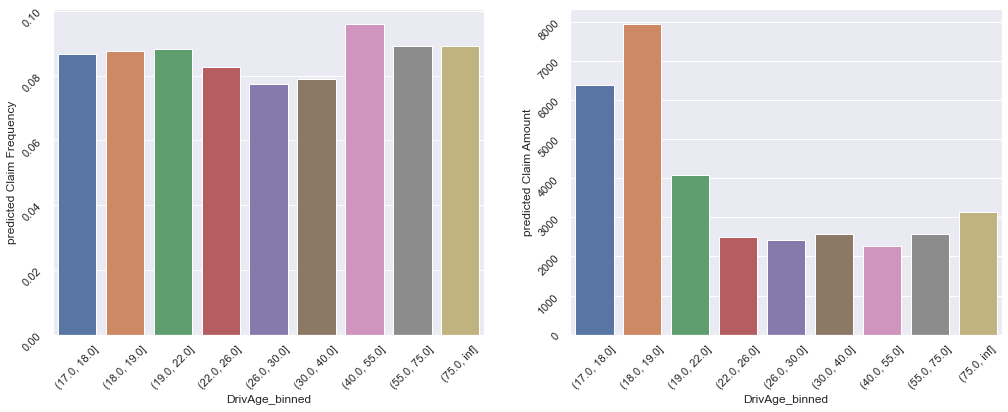

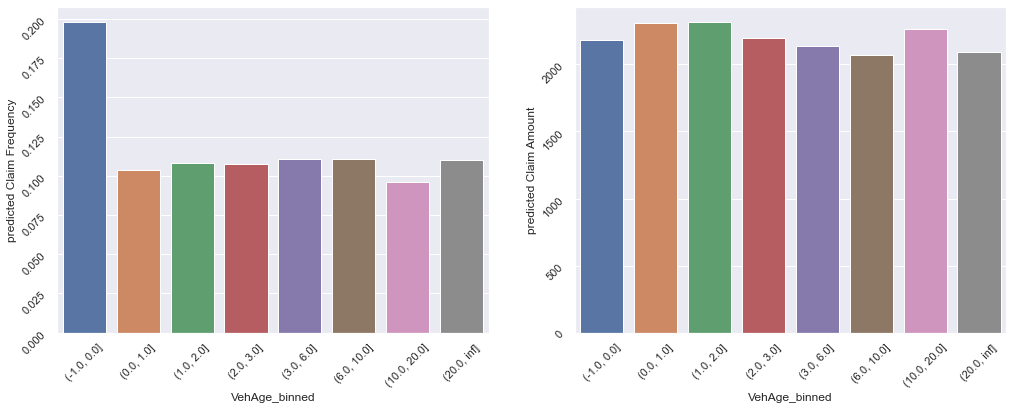

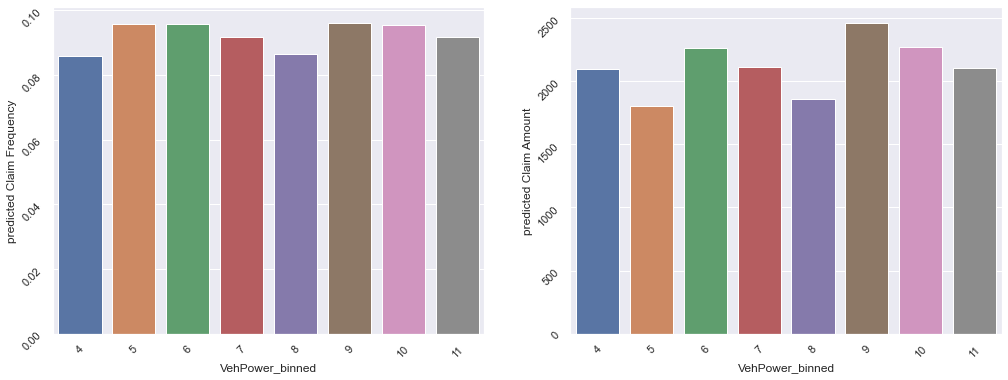

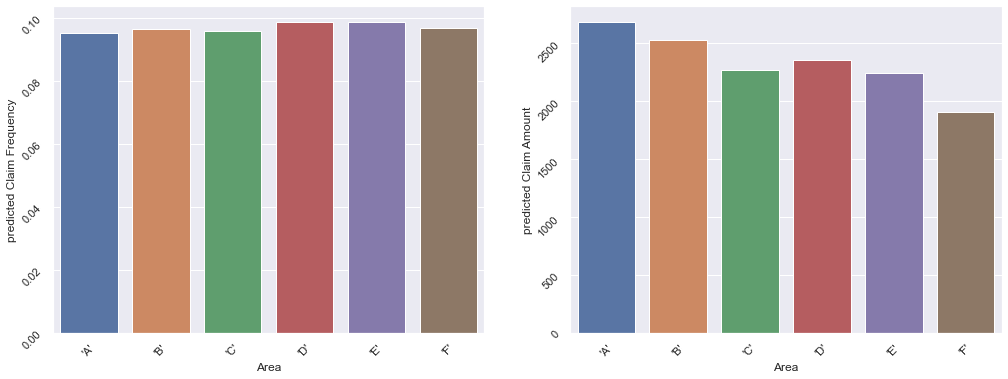

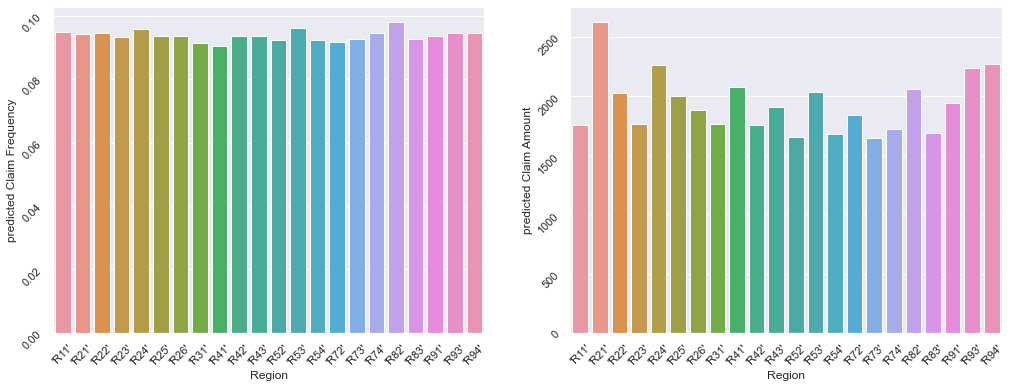

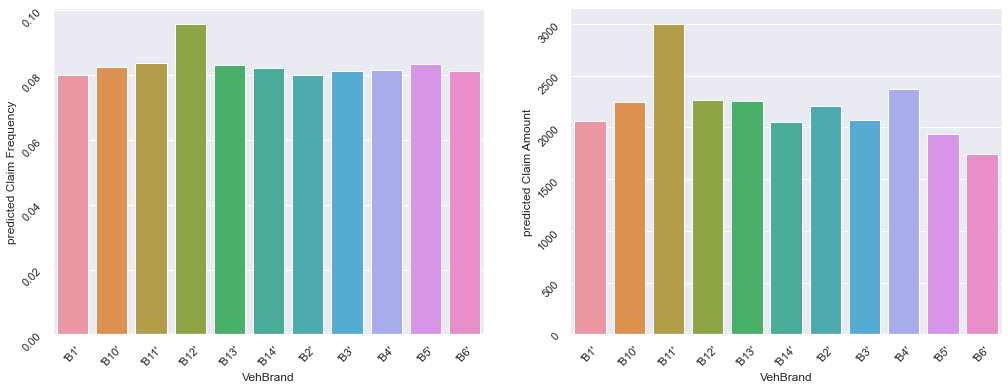

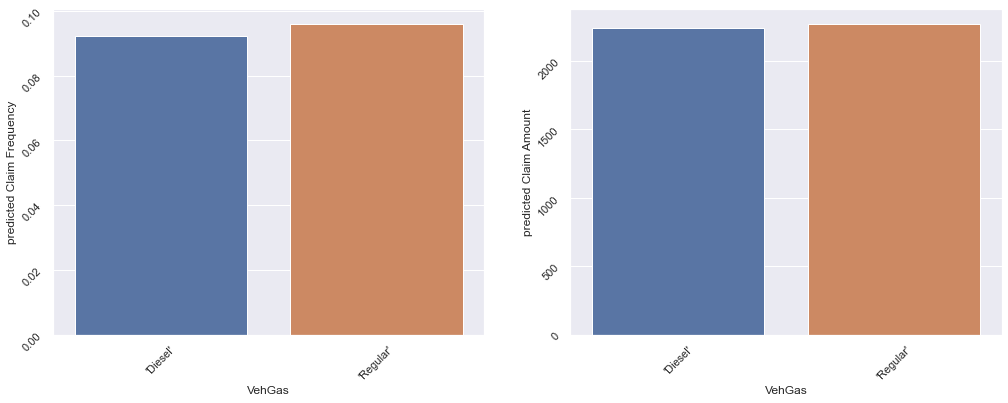

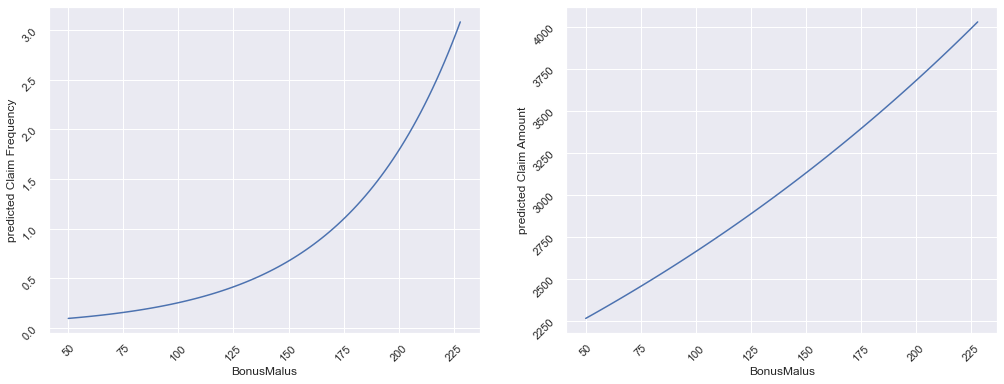

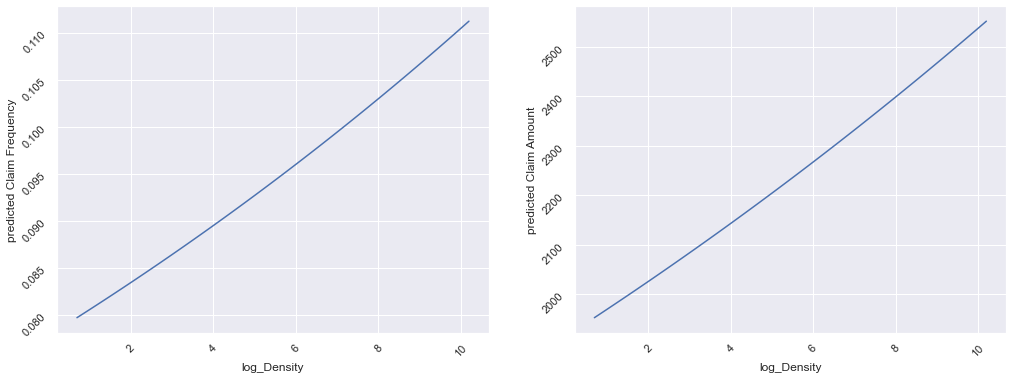

In [297]:
for pred in used_features:
    impact_plot(pred)

In [298]:
used_features

['DrivAge_binned',
 'VehAge_binned',
 'VehPower_binned',
 'Area',
 'Region',
 'VehBrand',
 'VehGas',
 'BonusMalus',
 'log_Density']